# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [406]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

## Load Data

In [542]:
# update this as needed!

# right now, only looking at tournament seed / performance, not regular season games
data_dir = './WDataFiles/'
data_dir_1 = './WPrelimData2018/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir_1 + 'WNCAATourneyCompactResults_PrelimData2018.csv')

df_tour = pd.read_csv(data_dir_1 + 'WNCAATourneyDetailedResults_PrelimData2018.csv')
df_reg_compact = pd.read_csv(data_dir_1+'WRegularSeasonCompactResults_PrelimData2018.csv')

df_reg_detail = pd.read_csv('./WPrelimData2018/WRegularSeasonDetailedResults_PrelimData2018.csv')

df_teams = pd.read_csv(data_dir + 'WTeams.csv')

In [543]:
# Add winning an losing team names to the regular compact and tour compact dataframes

df_teams_w = df_teams.rename(columns={'TeamID':'WTeamID','TeamName':'WTeamName'})
df_teams_l = df_teams.rename(columns={'TeamID':'LTeamID','TeamName':'LTeamName'})

df_reg_compact = pd.merge(left=df_reg_compact, right=df_teams_w, how='left', on=['WTeamID'])
df_reg_compact = pd.merge(left=df_reg_compact, right=df_teams_l, how='left', on=['LTeamID'])
df_reg_compact.head()

df_tour_compact = pd.merge(left=df_tour_compact, right=df_teams_w, how='left', on=['WTeamID'])
df_tour_compact = pd.merge(left=df_tour_compact, right=df_teams_l, how='left', on=['LTeamID'])



In [544]:
# Get the top 15 teams that are seeded No 1

df_seeds['SeedNo'] = df_seeds.loc[:,['Seed']].apply(lambda x: x['Seed'][-1:] ,axis=1)

df_seeds = pd.merge(left=df_seeds, right=df_teams, how='left', on=['TeamID'])


df_seeds.loc[df_seeds.SeedNo == '1',:]

df_teams_seed_count = pd.DataFrame({'count':df_seeds.loc[df_seeds.SeedNo == '1',:].groupby(['TeamID','TeamName']).size()}).reset_index()

df_teams_seed_count_top_15 = df_teams_seed_count.nlargest(15,'count').sort_values('count',axis=0,ascending=False)


In [545]:
# Get the top 15 teams that have won the maximum number of regular season games

df_reg_compact_team_wins = df_reg_compact[['WTeamName','WTeamID']]

df_reg_compact_team_wins = pd.DataFrame({'count':df_reg_compact_team_wins.groupby(['WTeamID','WTeamName']).size()}).reset_index()

df_reg_compact_team_wins_top_15 = df_reg_compact_team_wins.nlargest(15,'count').sort_values('count',axis=0,ascending=False)

In [546]:
# Get the top 15 teams that have won the maximum number of tour season games

df_tour_compact_team_wins = df_tour_compact[['WTeamName','WTeamID']]

df_tour_compact_team_wins = pd.DataFrame({'count':df_tour_compact_team_wins.groupby(['WTeamID','WTeamName']).size()}).reset_index() \
.rename(columns={'WTeamID':'TeamID','WTeamName':'TeamName'})

df_tour_compact_team_wins_top_15 = df_tour_compact_team_wins.nlargest(15,'count').sort_values('count',axis=0,ascending=False)


In [547]:
# Get the top teams that have won the maximum number of NCAA championships


df_tour_compact.sort_values(['Season', 'DayNum'], inplace=True)
    
df_tour_compact_champs = df_tour_compact.drop_duplicates(['Season'], keep='last', inplace=False)

df_tour_compact_champs = pd.DataFrame({'count':df_tour_compact_champs.groupby(['WTeamID','WTeamName']).size()}).reset_index() \
.rename(columns={'WTeamID':'TeamID','WTeamName':'TeamName'})


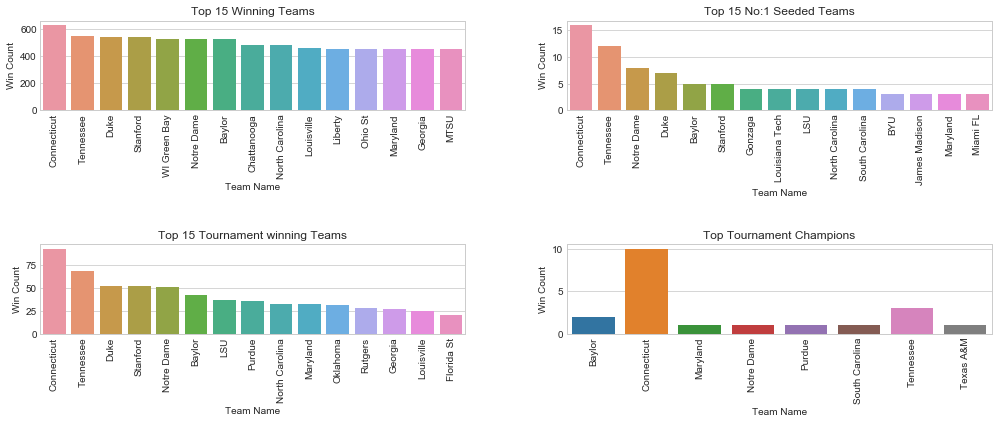

In [548]:
# Set up the figure,axes and style for the plots
fig, axes = plt.subplots(nrows=2,ncols=2, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)
fig.set_size_inches(15, 5, forward=True)
sns.set_style("whitegrid")

# Plot a barplot for Top 15 Winning Teams
ax = sns.barplot(x="WTeamName", y="count", data=df_reg_compact_team_wins_top_15,ax=axes[0,0])
ax.set(xlabel='Team Name', ylabel='Win Count')
ax.set_title('Top 15 Winning Teams')

for item in ax.get_xticklabels():
    item.set_rotation(90)

# Plot a barplot for Top 15 No:1 Seeded Teams

ax1 = sns.barplot(x="TeamName", y="count", data=df_teams_seed_count_top_15,ax=axes[0,1])
ax1.set(xlabel='Team Name', ylabel='Win Count')
ax1.set_title('Top 15 No:1 Seeded Teams')


for item in ax1.get_xticklabels():
    item.set_rotation(90)
    
# Plot a barplot for Top 15 Tournament winning Teams

ax1 = sns.barplot(x="TeamName", y="count", data=df_tour_compact_team_wins_top_15,ax=axes[1,0])
ax1.set(xlabel='Team Name', ylabel='Win Count')
ax1.set_title('Top 15 Tournament winning Teams')


for item in ax1.get_xticklabels():
    item.set_rotation(90)
    
# Plot a barplot for Top Tournament Champions

ax1 = sns.barplot(x="TeamName", y="count", data=df_tour_compact_champs,ax=axes[1,1])
ax1.set(xlabel='Team Name', ylabel='Win Count')
ax1.set_title('Top Tournament Champions')


for item in ax1.get_xticklabels():
    item.set_rotation(90)



# Indicators of Regular Season Success

Let’s now turn to the regular season game statistics. We are interested in knowing how certain statistics correlate with winning vs losing. We will take the regular season detail and first convert it to a more ‘long’ format with only 1 column of TeamIDs and a factor indicating whether that row corresponds to a win or a loss. Here I also add some additional game statistcs. These include field goal percentage, free throw percentage, offensive/defensive rebounding efficiency, and possessions. 

In [549]:
# Calculate additional metrics for the winning team

# Calculate Field Goal Percentage 

df_reg_detail['WFGP'] = df_reg_detail.WFGM / df_reg_detail.WFGA

# Calculate 2Pt Field Goal Percentage

df_reg_detail['WFGP2'] = (df_reg_detail.WFGM - df_reg_detail.WFGM3) / (df_reg_detail.WFGA - df_reg_detail.WFGA3)

# Calculate 3Pt Field Goal Percentage

df_reg_detail['WFGP3'] = df_reg_detail.WFGM3 / df_reg_detail.WFGA3

# Calculate Free Throw Shooting

df_reg_detail['WFTP'] = df_reg_detail.WFTM / df_reg_detail.WFTA

# Calculate Offensive Rebounding Efficiency

df_reg_detail['WORP'] = df_reg_detail.WOR / (df_reg_detail.WOR + df_reg_detail.LDR)

# Calculate Defensive Rebounding Efficiency

df_reg_detail['WDRP'] = df_reg_detail.WDR / (df_reg_detail.WDR + df_reg_detail.LOR)

# Calculate Possessions

df_reg_detail['WPOS'] = 0.96 * (df_reg_detail.WFGA + df_reg_detail.WTO + 0.44 * df_reg_detail.WFTA - df_reg_detail.WOR)

In [550]:
# Calculate additional metrics for the Losing team

# Calculate Field Goal Percentage 

df_reg_detail['LFGP'] = df_reg_detail.LFGM / df_reg_detail.LFGA

# Calculate 2Pt Field Goal Percentage

df_reg_detail['LFGP2'] = (df_reg_detail.LFGM - df_reg_detail.LFGM3) / (df_reg_detail.LFGA - df_reg_detail.LFGA3)

# Calculate 3Pt Field Goal Percentage

df_reg_detail['LFGP3'] = df_reg_detail.LFGM3 / df_reg_detail.LFGA3

# Calculate Free Throw Shooting

df_reg_detail['LFTP'] = df_reg_detail.LFTM / df_reg_detail.LFTA

# Calculate Offensive Rebounding Efficiency

df_reg_detail['LORP'] = df_reg_detail.LOR / (df_reg_detail.LOR + df_reg_detail.LDR)

# Calculate Defensive Rebounding Efficiency

df_reg_detail['LDRP'] = df_reg_detail.LDR / (df_reg_detail.LDR + df_reg_detail.LOR)

# Calculate Possessions

df_reg_detail['LPOS'] = 0.96 * (df_reg_detail.LFGA + df_reg_detail.LTO + 0.44 * df_reg_detail.LFTA - df_reg_detail.LOR)

In [551]:
# Get the list of all winning team features

Win_Features = list(filter(None,[a if a[0]== 'W' else None for a in df_reg_detail.columns.values]))

# Get the list of all losing team features

Loss_Features = list(filter(None,[a if a[0]== 'L' else None for a in df_reg_detail.columns.values]))

# Add the winning team location - This feature will be transformed at a later point to provide the perspective of the losing team

Loss_Features.insert(2,'WLoc')

# Get the list of generic features for both the winning and the losing team

Consolidated_Features = list(map(lambda x : x[1:],Win_Features))

# Extract the winning team information from the regular season detail

df_reg_detail_winners = df_reg_detail.loc[:,Win_Features].rename(columns = dict(zip(Win_Features,Consolidated_Features))).reset_index()

#  Set the outcome variable to 'W' to denote a win

df_reg_detail_winners['Outcome'] = 'W'

# Extract the losing team information from the regular season detail

df_reg_detail_losers =  df_reg_detail.loc[:,Loss_Features].rename(columns = dict(zip(Loss_Features,Consolidated_Features))).reset_index()

#  Set the outcome variable to 'L' to denote a loss

df_reg_detail_losers['Outcome'] = 'L'

# Concatenate the winning features and the losing features

df_reg_detail_winners_losers = df_reg_detail_winners.iloc[0:df_reg_detail_winners.shape[0]-1].append(df_reg_detail_losers.iloc[0:df_reg_detail_losers.shape[0]-1]).reset_index()

/Users/arganesa/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/arganesa/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


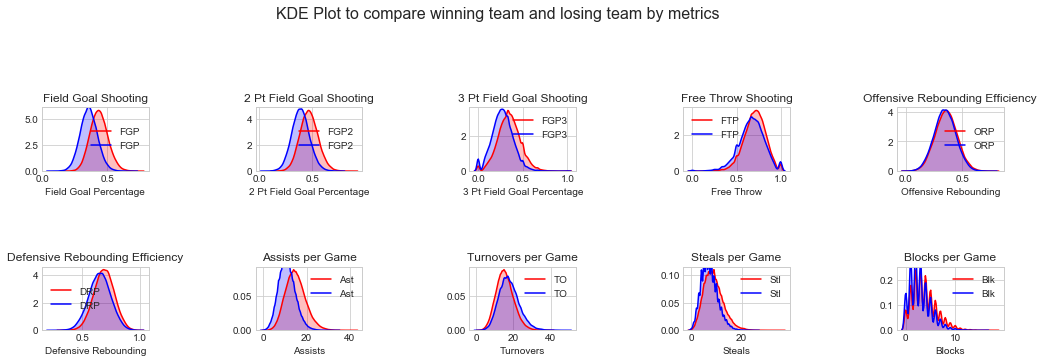

In [573]:
# Plot kernal density plots for the various metrics to show the metrics distribution when winning and losing.

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=1.5)
fig.set_size_inches(15, 5, forward=True)


g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].FGP, shade=True, color="r",ax=ax[0,0],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].FGP, shade=True, color="b",ax=ax[0,0],legend=True)


ax[0,0].set_title('Field Goal Shooting')
ax[0,0].set_xlabel('Field Goal Percentage')

g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].FGP2, shade=True, color="r",ax=ax[0,1],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].FGP2, shade=True, color="b",ax=ax[0,1],legend=True)

ax[0,1].set_title('2 Pt Field Goal Shooting')
ax[0,1].set_xlabel('2 Pt Field Goal Percentage')

g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].FGP3, shade=True, color="r",ax=ax[0,2],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].FGP3, shade=True, color="b",ax=ax[0,2],legend=True)

ax[0,2].set_title('3 Pt Field Goal Shooting')
ax[0,2].set_xlabel('3 Pt Field Goal Percentage')

g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].FTP, shade=True, color="r",ax=ax[0,3],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].FTP, shade=True, color="b",ax=ax[0,3],legend=True)

ax[0,3].set_title('Free Throw Shooting')
ax[0,3].set_xlabel('Free Throw')


g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].ORP, shade=True, color="r",ax=ax[0,4],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].ORP, shade=True, color="b",ax=ax[0,4],legend=True)
ax[0,4].set_title('Offensive Rebounding Efficiency')
ax[0,4].set_xlabel('Offensive Rebounding')


g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].DRP, shade=True, color="r",ax=ax[1,0],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].DRP, shade=True, color="b",ax=ax[1,0],legend=True)
ax[1,0].set_title('Defensive Rebounding Efficiency')

ax[1,0].set_xlabel('Defensive Rebounding')

g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].Ast, shade=True, color="r",ax=ax[1,1],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].Ast, shade=True, color="b",ax=ax[1,1],legend=True)

ax[1,1].set_title('Assists per Game')
ax[1,1].set_xlabel('Assists')

g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].TO, shade=True, color="r",ax=ax[1,2],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].TO, shade=True, color="b",ax=ax[1,2],legend=True)

ax[1,2].set_title('Turnovers per Game')
ax[1,2].set_xlabel('Turnovers')

g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].Stl, shade=True, color="r",ax=ax[1,3],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].Stl, shade=True, color="b",ax=ax[1,3],legend=True)

ax[1,3].set_title('Steals per Game')
ax[1,3].set_xlabel('Steals')

g1 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='W'].Blk, shade=True, color="r",ax=ax[1,4],legend=True)

g2 = sns.kdeplot(df_reg_detail_winners_losers.loc[df_reg_detail_winners_losers.Outcome=='L'].Blk, shade=True, color="b",ax=ax[1,4],legend=True)

ax[1,4].set_title('Blocks per Game')
ax[1,4].set_xlabel('Blocks')

fig.suptitle("KDE Plot to compare winning team and losing team by metrics", size=16)
fig.subplots_adjust(top=0.7)

# Predictors of Tournament Success

One of the obvious predictors for how deep a team goes in the tournament would be regular season wins. Let’s see how regular season wins correlate to tournament progress each year.

In [555]:
# Get the count of team wins by team and season for the regular season

df_reg_compact_team_wins_by_season = df_reg_compact[['WTeamName','WTeamID','Season']]

df_reg_compact_team_wins_by_season = pd.DataFrame({'count':df_reg_compact_team_wins_by_season.groupby(['WTeamID','WTeamName','Season']).size()}).reset_index() \
.rename(columns={'WTeamID':'TeamID','WTeamName':'TeamName'})

# Get the count of team wins by team and season for the tour

df_tour_compact_team_wins_by_season = df_tour_compact[['WTeamName','WTeamID','Season']]

df_tour_compact_team_wins_by_season = pd.DataFrame({'count':df_tour_compact_team_wins_by_season.groupby(['WTeamID','WTeamName','Season']).size()}).reset_index() \
.rename(columns={'WTeamID':'TeamID','WTeamName':'TeamName'})

# Merge regular season and tour records by team and season. 

df_teams_wins_reg_tour_by_season = pd.merge(df_reg_compact_team_wins_by_season,df_tour_compact_team_wins_by_season,'inner',on=['TeamID','TeamName','Season'])

# Rename the columns to give appropriate names

df_teams_wins_reg_tour_by_season=df_teams_wins_reg_tour_by_season.rename(columns={'count_x':'Reg_Season_Wins','count_y':'Tour_Wins'})

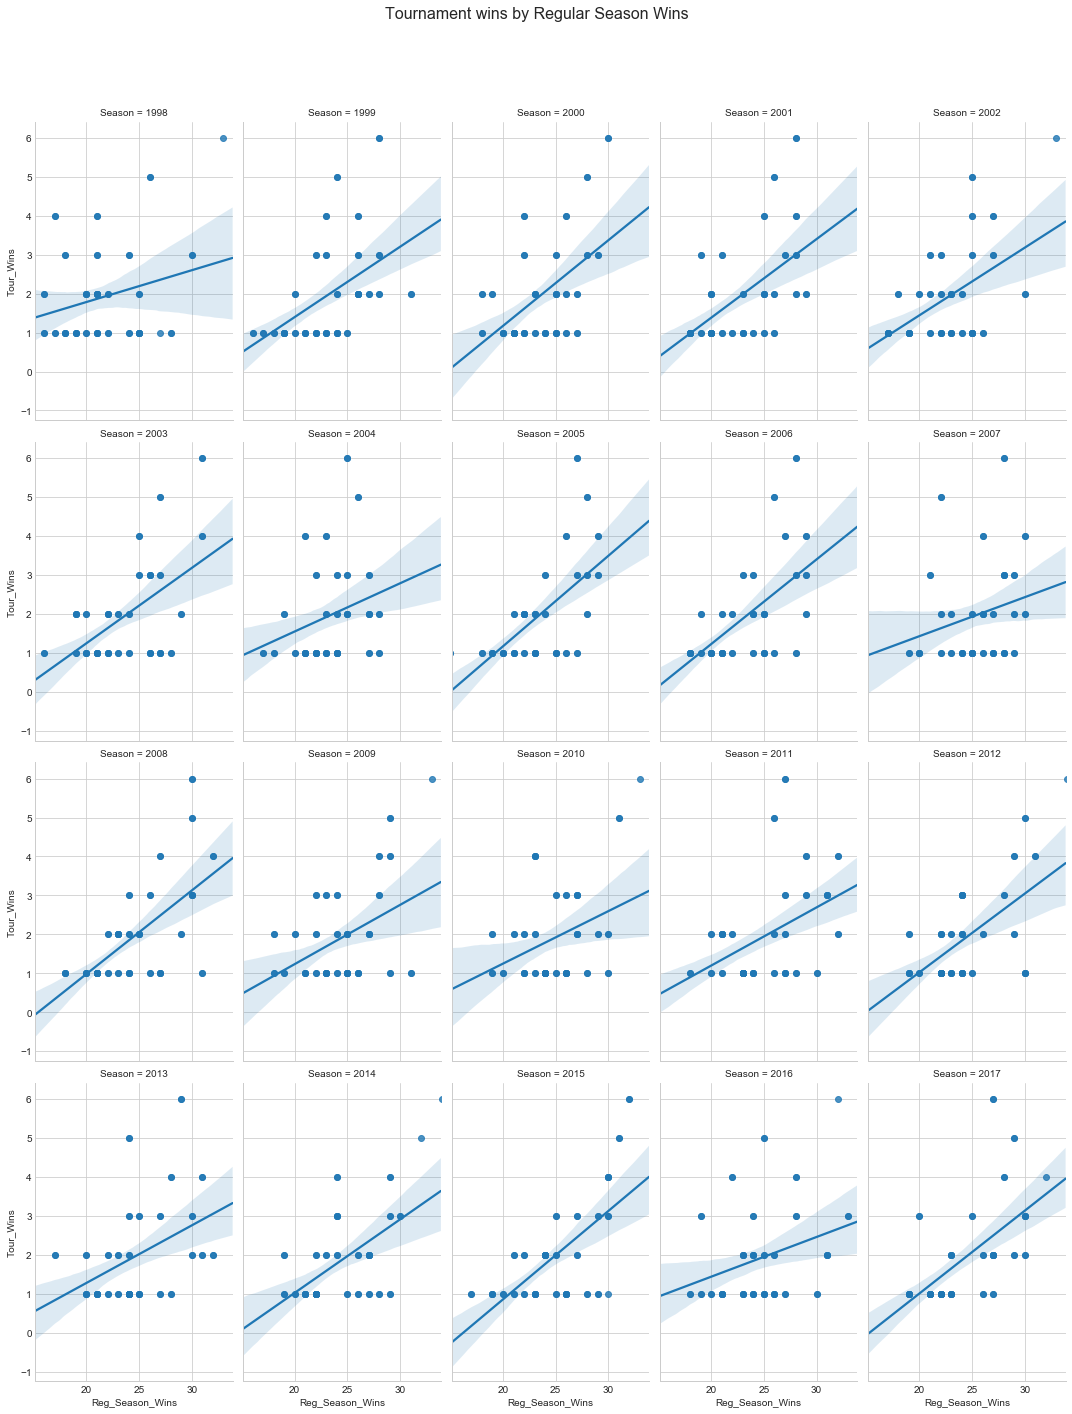

In [565]:
# Plot scatterplot by season to compare regular season wins and tournament wins

g = sns.FacetGrid(df_teams_wins_reg_tour_by_season, col="Season",size=5,aspect=0.6,col_wrap=5)
g = g.map(sns.regplot,"Reg_Season_Wins","Tour_Wins")
g.fig.suptitle("Tournament wins by Regular Season Wins", size=16)
g.fig.subplots_adjust(top=.9)

In [557]:
# Get the total score and num of wins for the winning team
df_reg_teams_wins_scores = df_reg_compact.groupby(['WTeamID','WTeamName','Season']).agg({'WScore' : ['sum','count']}).reset_index()

# Get the total score and num of wins for the losing team

df_reg_teams_loss_scores = df_reg_compact.groupby(['LTeamID','LTeamName','Season']).agg({'LScore' : ['sum','count']}).reset_index()

# Calculate the average score for the winning teams
df_reg_teams_wins_scores['Avg_Reg_Score'] = df_reg_teams_wins_scores['WScore','sum'] /df_reg_teams_wins_scores['WScore','count']

# Calculate the average score for the losing teams
df_reg_teams_loss_scores['Avg_Reg_Score'] = df_reg_teams_loss_scores['LScore','sum'] /df_reg_teams_loss_scores['LScore','count']

# Rename columns so that datasets can be appended
df_reg_teams_wins_scores = df_reg_teams_wins_scores.rename(columns={'WTeamID':'TeamID','WTeamName':'TeamName'})
df_reg_teams_loss_scores = df_reg_teams_loss_scores.rename(columns={'LTeamID':'TeamID','LTeamName':'TeamName'})

# Concatenate winning and losing team's average scores
df_reg_teams_Avg_scores = df_reg_teams_wins_scores[['TeamID','TeamName','Season','Avg_Reg_Score']].append(df_reg_teams_loss_scores[['TeamID','TeamName','Season','Avg_Reg_Score']])

# Drop a level to flatten the columns.
df_reg_teams_Avg_scores.columns=df_reg_teams_Avg_scores.columns.droplevel(level=1)

# Add the average score of the teams in the regular season to the df_teams_wins_reg_tour_by_season dataframe
df_teams_wins_reg_tour_by_season = pd.merge(df_teams_wins_reg_tour_by_season,df_reg_teams_Avg_scores,'left',on=['TeamID','TeamName','Season'])


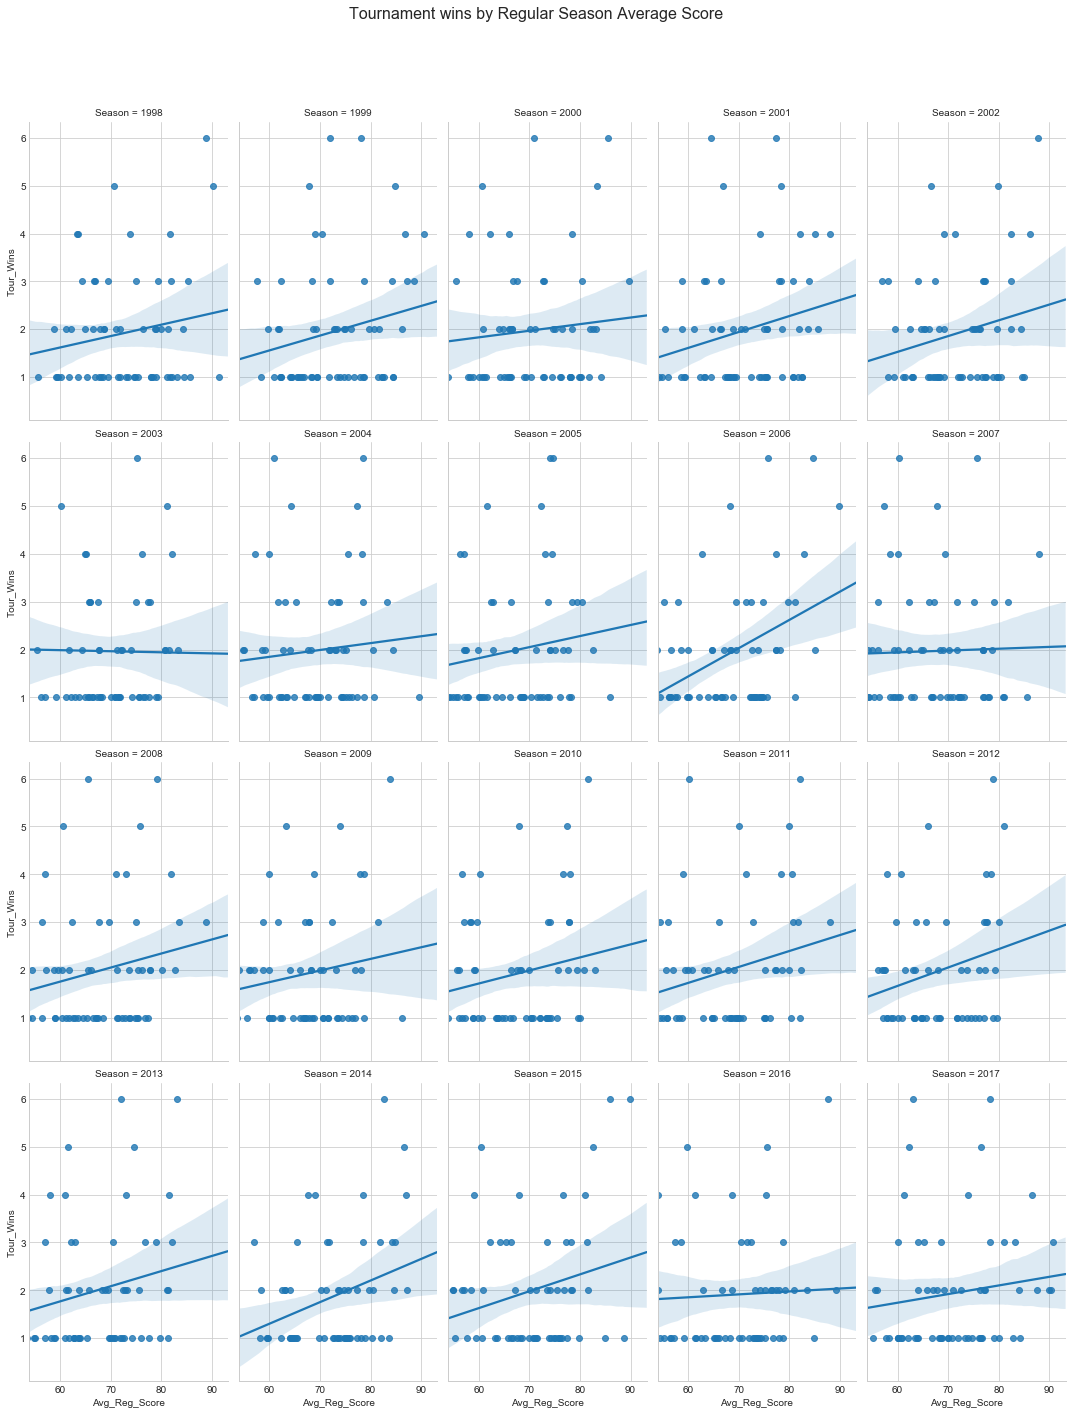

In [566]:
# Plot scatterplot by season to compare regular season average scores and tournament wins

g = sns.FacetGrid(df_teams_wins_reg_tour_by_season, col="Season",size=5,aspect=0.6,col_wrap=5)
g = g.map(sns.regplot,"Avg_Reg_Score","Tour_Wins")
g.fig.suptitle("Tournament wins by Regular Season Average Score", size=16)
g.fig.subplots_adjust(top=.9)

In [ ]:
# Caluclation of Elo Rating
K = 20.
HOME_ADVANTAGE = 100.
team_ids = set(df_reg_season.WTeamID).union(set(df_reg_season.LTeamID))
# This dictionary will be used as a lookup for current
# scores while the algorithm is iterating through each game
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [17]:
df_reg_season['margin'] = df_reg_season.WScore - df_reg_season.LScore

In [18]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [25]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in df_reg_season.itertuples():
    
    # Get key data from current row
    w = row.WTeamID
    l = row.LTeamID
    margin = row.margin
    wloc = row.WLoc
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [26]:
df_reg_season['w_elo'] = w_elo
df_reg_season['l_elo'] = l_elo

In [27]:
df_reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,margin,w_elo,l_elo
0,1998,18,3104,91,3202,41,H,0,50,1521.290691,1478.709309
1,1998,18,3163,87,3221,76,H,0,11,1507.339585,1492.660415
2,1998,18,3222,66,3261,59,H,0,7,1505.607497,1494.392503
3,1998,18,3307,69,3365,62,H,0,7,1505.607497,1494.392503
4,1998,18,3349,115,3411,35,H,0,80,1530.481163,1469.518837


In [41]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    
    d.drop_duplicates(['Season'], keep='last', inplace=True)
        
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo,
        'daynum':d.DayNum
        
    })
    return(out)

In [42]:
df_list = [final_elo_per_season(df_reg_season, id) for id in team_ids]
season_elos = pd.concat(df_list)

In [43]:
season_elos.sample(10)


,daynum,season,season_elo,team_id
85993,123,2015,1783.82,3242
91292,124,2016,1420.29,3463
16856,126,2001,1765.64,3408
70476,127,2012,961.059,3115
25860,124,2003,1405.62,3447
8125,130,1999,1565.26,3232
80934,127,2014,1859.27,3385
50022,130,2008,1188.55,3290
35050,124,2005,1236.71,3144
16719,123,2001,1300.71,3348


In [51]:
# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'team_id', 'Season':'season'})
df_season_elos = pd.merge(left=season_elos, right=df_W, how='left', on=['season', 'team_id'])

df_season_elos.head(10)

,daynum,season,season_elo,team_id,Seed
0,124,2014,1466.83,3101,NaN
1,124,2015,1387.81,3101,NaN
2,124,2016,1548.17,3101,NaN
3,124,2017,1561.99,3101,NaN
4,122,1998,1288.37,3102,NaN
5,124,1999,1199.07,3102,NaN
6,128,2000,1163.32,3102,NaN
7,128,2001,1142.51,3102,NaN
8,128,2002,1150.93,3102,NaN
9,128,2003,1156.84,3102,NaN


In [49]:
df_season_elos['Seed'].unique()

array([nan, 'Z13', 'Y15', 'W15', 'X13', 'Z12', 'W16', 'Z14', 'Z09', 'Y03',
       'Z02', 'Z08', 'Y11', 'Z10', 'Y13', 'X09', 'X01', 'W13', 'X15',
       'W14', 'W12', 'W07', 'Z07', 'W04', 'X14', 'Y14', 'Z11', 'X07',
       'W11', 'W01', 'X16', 'X06', 'X12', 'Y10', 'W02', 'X04', 'W09',
       'Y07', 'X11', 'Z05', 'X10', 'Y02', 'X05', 'Z03', 'W08', 'Y08',
       'W06', 'Y09', 'Y06', 'W10', 'Z16', 'Y12', 'Y04', 'Z15', 'W03',
       'X03', 'X08', 'Y05', 'Z04', 'W05', 'X02', 'Z06', 'Y16', 'Z01', 'Y01'], dtype=object)

In [4]:
# seed = region + seed within region (1-16)
df_seeds.tail(10)

,Season,Seed,TeamID
1270,2017,Z07,3166
1271,2017,Z08,3113
1272,2017,Z09,3277
1273,2017,Z10,3405
1274,2017,Z11,3378
1275,2017,Z12,3346
1276,2017,Z13,3195
1277,2017,Z14,3442
1278,2017,Z15,3253
1279,2017,Z16,3421


In [5]:
# contains winning and losing team IDs (must check against list of teams)
# winning and losing team scores
# WLoc = home (H), away (A), neutral (N)
df_tour.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1250,2017,145,3199,66,3333,53,N,0
1251,2017,145,3332,77,3268,63,N,0
1252,2017,145,3376,100,3346,58,N,0
1253,2017,146,3280,94,3124,85,N,1
1254,2017,146,3390,76,3323,75,N,0
1255,2017,147,3163,90,3332,52,H,0
1256,2017,147,3376,71,3199,64,N,0
1257,2017,151,3280,66,3163,64,N,1
1258,2017,151,3376,62,3390,53,N,0
1259,2017,153,3376,67,3280,55,N,0


## Merge

In [8]:
df_W.head()

,Season,WSeed,WTeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [44]:
# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
df_L = df_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_W, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_L, on=['Season', 'LTeamID'])

# at the beginning of the tourney, teams play within their region
# final 3 games = between regions
df_concat.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed
242,2017,145,3199,66,3333,53,N,0,Z03,Z02
243,2017,145,3332,77,3268,63,N,0,W10,W03
244,2017,145,3376,100,3346,58,N,0,Z01,Z12
245,2017,146,3280,94,3124,85,N,1,X02,X01
246,2017,146,3390,76,3323,75,N,0,Y02,Y01
247,2017,147,3163,90,3332,52,H,0,W01,W10
248,2017,147,3376,71,3199,64,N,0,Z01,Z03
249,2017,151,3280,66,3163,64,N,1,X02,W01
250,2017,151,3376,62,3390,53,N,0,Z01,Y02
251,2017,153,3376,67,3280,55,N,0,Z01,X02


In [9]:
# calculate seed differential: positive = higher seed won, negative = lower seed won
df_concat['SeedDiff'] = df_concat.apply(lambda row: int(row['LSeed'][1:3]) - int(row['WSeed'][1:3]), axis=1)

df_concat.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,SeedDiff
1250,2017,145,3199,66,3333,53,N,0,Z03,Z02,-1
1251,2017,145,3332,77,3268,63,N,0,W10,W03,-7
1252,2017,145,3376,100,3346,58,N,0,Z01,Z12,11
1253,2017,146,3280,94,3124,85,N,1,X02,X01,-1
1254,2017,146,3390,76,3323,75,N,0,Y02,Y01,-1
1255,2017,147,3163,90,3332,52,H,0,W01,W10,9
1256,2017,147,3376,71,3199,64,N,0,Z01,Z03,2
1257,2017,151,3280,66,3163,64,N,1,X02,W01,-1
1258,2017,151,3376,62,3390,53,N,0,Z01,Y02,1
1259,2017,153,3376,67,3280,55,N,0,Z01,X02,1


In [25]:
# Baseline: just use seed information? 
# Baseline: 50/50 chance? (even easier)

In [10]:
# Stage 1: submission file
# Make predictions for all possible matchups from the past four NCAA® tournaments 2014-2017
# (64*63/2 = 2,016 predictions per year)
recent_tourney_teams = df_seeds = df_seeds[df_seeds['Season'] > 2013]
recent_tourney_teams = recent_tourney_teams.reset_index(drop=True)
recent_tourney_teams.head(10)

# how to match these up pairwise each year??

# ID - string SSSS_XXXX_YYYY, SSSS = 4-digit season yr, 
# XXXX  = 4-digit TeamID of lower-ID team, YYYY = 4-digit TeamID of higher-ID team.
# Pred - predicted winning percentage for the first team in the ID field

,Season,Seed,TeamID
0,2014,W01,3163
1,2014,W02,3181
2,2014,W03,3401
3,2014,W04,3304
4,2014,W05,3301
5,2014,W06,3211
6,2014,W07,3177
7,2014,W08,3208
8,2014,W09,3386
9,2014,W10,3328


In [14]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()


(1260, 2)

In [28]:
## Create training and test data sets; may create a dev dataset later
num_test = len(df_predictions)

# TODO: Add dev data!
mask = np.random.rand(len(df_predictions)) < 0.8 ## 80% data for training and 20% for testing
train_data = df_predictions[mask]
test_data = df_predictions[~mask]

#test_data, test_labels = df_predictions.data[num_test/2:], newsgroups_test.target[num_test/2:]
#dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
#train_data, train_labels = newsgroups_train.data, newsgroups_train.target


In [29]:
## Convert to arrays
X_train = train_data.SeedDiff.values.reshape(-1,1)
y_train = train_data.Result.values
X_test = test_data.SeedDiff.values.reshape(-1,1)
y_test = test_data.Result.values

In [30]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4664, with best C: 0.1


Text(0,0.5,u'P(Team1 will win)')

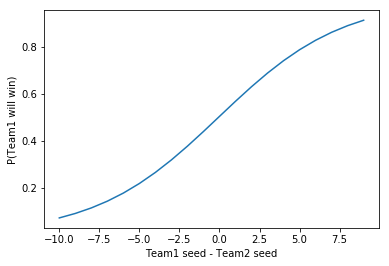

In [31]:
## Plot to confirm intuition that greater positive seed difference indicates higher win probability
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [32]:
df_sample_sub = pd.read_csv('WSampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))


In [33]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label


In [34]:
## Unpack the ID field for team IDs
## Look up seeds for the team
## Calculate seed difference

X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed


In [36]:
## Make predictions

preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head(10)

,ID,Pred
0,2014_3103_3107,0.376260
1,2014_3103_3113,0.739968
2,2014_3103_3119,0.502908
3,2014_3103_3124,0.945607
4,2014_3103_3140,0.567136
5,2014_3103_3143,0.826767
6,2014_3103_3151,0.629184
7,2014_3103_3163,0.950000
8,2014_3103_3169,0.317780
9,2014_3103_3173,0.860737


In [38]:
df_sample_sub.to_csv('test-submission.csv', index=False)